[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    flattened_revlogs = []
    for i, r in enumerate([0.8]):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=r,
            deck_size=30000,
            learn_span=learn_span,
            max_cost_perday=3600,
            first_rating_offset=np.array([0, 0, 0, 0]),
            first_session_len=np.array([0, 0, 0, 0]),
            forget_rating_offset=0,
            forget_session_len=0,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * 30000,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2623


  0%|          | 0/2623 [00:00<?, ?it/s]

loss before: 0.5099, loss after: 0.4732
RMSE(bins): 0.0333
AUC: 0.6113
1.1596 -> 1.0457: SMAPE=10.3297%
1.7974 -> 2.505: SMAPE=32.8933%
13.1205 -> 14.7747: SMAPE=11.8601%
49.3729 -> 66.9959: SMAPE=30.2882%
7.2303 -> 7.0888: SMAPE=1.9764%
0.5081 -> 0.5995: SMAPE=16.5042%
1.5371 -> 1.447: SMAPE=6.0387%
0.001 -> 0.012: SMAPE=169.2308%
1.5052 -> 1.7307: SMAPE=13.9374%
0.1261 -> 0.3215: SMAPE=87.3101%
0.9735 -> 1.2061: SMAPE=21.3434%
1.8924 -> 1.8236: SMAPE=3.7029%
0.1486 -> 0.1884: SMAPE=23.6202%
0.2407 -> 0.1957: SMAPE=20.6233%
2.1937 -> 2.1792: SMAPE=0.6632%
0.1518 -> 0.1379: SMAPE=9.5961%
3.0699 -> 3.0841: SMAPE=0.4615%
1 -> 0.412: SMAPE=83.2861%
Avg. SMAPE: 30.2036%
loss before: 0.5099, loss after: 0.4760
RMSE(bins): 0.0345
AUC: 0.6098
--------------------------------
learn_span: 60


sample size: 7286


  0%|          | 0/7286 [00:00<?, ?it/s]

loss before: 0.5470, loss after: 0.5038
RMSE(bins): 0.0310
AUC: 0.5576
1.1596 -> 0.9985: SMAPE=14.9298%
1.7974 -> 1.8456: SMAPE=2.6462%
13.1205 -> 12.2142: SMAPE=7.1546%
49.3729 -> 61.0929: SMAPE=21.2192%
7.2303 -> 7.229: SMAPE=0.0180%
0.5081 -> 0.4513: SMAPE=11.8407%
1.5371 -> 1.6615: SMAPE=7.7784%
0.001 -> 0.0016: SMAPE=46.1538%
1.5052 -> 1.4487: SMAPE=3.8255%
0.1261 -> 0.3628: SMAPE=96.8296%
0.9735 -> 0.9453: SMAPE=2.9393%
1.8924 -> 1.829: SMAPE=3.4073%
0.1486 -> 0.214: SMAPE=36.0728%
0.2407 -> 0.2267: SMAPE=5.9906%
2.1937 -> 2.2438: SMAPE=2.2580%
0.1518 -> 0.3146: SMAPE=69.8113%
3.0699 -> 2.8601: SMAPE=7.0759%
1 -> 0.3272: SMAPE=101.3864%
Avg. SMAPE: 24.5188%
loss before: 0.5470, loss after: 0.5049
RMSE(bins): 0.0314
AUC: 0.5602
--------------------------------
learn_span: 120


sample size: 16437


  0%|          | 0/16437 [00:00<?, ?it/s]

loss before: 0.5471, loss after: 0.5108
RMSE(bins): 0.0213
AUC: 0.5532
1.1596 -> 1.1426: SMAPE=1.4768%
1.7974 -> 1.716: SMAPE=4.6337%
13.1205 -> 11.4779: SMAPE=13.3553%
49.3729 -> 39.3694: SMAPE=22.5451%
7.2303 -> 7.1889: SMAPE=0.5742%
0.5081 -> 0.5229: SMAPE=2.8710%
1.5371 -> 1.5393: SMAPE=0.1430%
0.001 -> 0.0036: SMAPE=113.0435%
1.5052 -> 1.4651: SMAPE=2.7001%
0.1261 -> 0.3159: SMAPE=85.8824%
0.9735 -> 0.9823: SMAPE=0.8999%
1.8924 -> 1.813: SMAPE=4.2856%
0.1486 -> 0.2142: SMAPE=36.1632%
0.2407 -> 0.2529: SMAPE=4.9433%
2.1937 -> 2.29: SMAPE=4.2956%
0.1518 -> 0.1318: SMAPE=14.1044%
3.0699 -> 2.814: SMAPE=8.6983%
1 -> 0.3217: SMAPE=102.6405%
Avg. SMAPE: 23.5142%
loss before: 0.5471, loss after: 0.5112
RMSE(bins): 0.0205
AUC: 0.5550
--------------------------------
learn_span: 240


sample size: 36515


  0%|          | 0/36515 [00:00<?, ?it/s]

loss before: 0.5340, loss after: 0.5062
RMSE(bins): 0.0175
AUC: 0.5565
1.1596 -> 1.0468: SMAPE=10.2248%
1.7974 -> 1.8114: SMAPE=0.7759%
13.1205 -> 11.3352: SMAPE=14.6003%
49.3729 -> 42.4567: SMAPE=15.0631%
7.2303 -> 7.2635: SMAPE=0.4581%
0.5081 -> 0.4328: SMAPE=16.0060%
1.5371 -> 1.617: SMAPE=5.0664%
0.001 -> 0.0056: SMAPE=139.3939%
1.5052 -> 1.4479: SMAPE=3.8807%
0.1261 -> 0.1268: SMAPE=0.5536%
0.9735 -> 1.0211: SMAPE=4.7729%
1.8924 -> 1.7481: SMAPE=7.9275%
0.1486 -> 0.2278: SMAPE=42.0829%
0.2407 -> 0.271: SMAPE=11.8429%
2.1937 -> 2.3005: SMAPE=4.7528%
0.1518 -> 0.2025: SMAPE=28.6198%
3.0699 -> 3.1452: SMAPE=2.4231%
1 -> 0.4075: SMAPE=84.1918%
Avg. SMAPE: 21.8131%
loss before: 0.5340, loss after: 0.5063
RMSE(bins): 0.0178
AUC: 0.5567
--------------------------------
learn_span: 480


sample size: 78318


  0%|          | 0/78318 [00:00<?, ?it/s]

loss before: 0.5263, loss after: 0.5018
RMSE(bins): 0.0141
AUC: 0.5490
1.1596 -> 1.0449: SMAPE=10.4060%
1.7974 -> 1.7236: SMAPE=4.1920%
13.1205 -> 11.9396: SMAPE=9.4245%
49.3729 -> 51.764: SMAPE=4.7284%
7.2303 -> 7.2462: SMAPE=0.2197%
0.5081 -> 0.3458: SMAPE=38.0138%
1.5371 -> 1.5636: SMAPE=1.7093%
0.001 -> 0.0046: SMAPE=128.5714%
1.5052 -> 1.4048: SMAPE=6.9003%
0.1261 -> 0.1494: SMAPE=16.9147%
0.9735 -> 1.125: SMAPE=14.4389%
1.8924 -> 1.6116: SMAPE=16.0274%
0.1486 -> 0.2245: SMAPE=40.6861%
0.2407 -> 0.2846: SMAPE=16.7143%
2.1937 -> 2.4643: SMAPE=11.6187%
0.1518 -> 0.2042: SMAPE=29.4382%
3.0699 -> 2.7078: SMAPE=12.5344%
1 -> 0.373: SMAPE=91.3328%
Avg. SMAPE: 25.2151%
loss before: 0.5263, loss after: 0.5019
RMSE(bins): 0.0136
AUC: 0.5488
--------------------------------
learn_span: 960


sample size: 164570


  0%|          | 0/164570 [00:00<?, ?it/s]

loss before: 0.5234, loss after: 0.5024
RMSE(bins): 0.0107
AUC: 0.5532
1.1596 -> 1.1202: SMAPE=3.4564%
1.7974 -> 1.8016: SMAPE=0.2334%
13.1205 -> 11.794: SMAPE=10.6484%
49.3729 -> 49.0179: SMAPE=0.7216%
7.2303 -> 7.0778: SMAPE=2.1317%
0.5081 -> 0.5314: SMAPE=4.4829%
1.5371 -> 1.5336: SMAPE=0.2280%
0.001 -> 0.0033: SMAPE=106.9767%
1.5052 -> 1.2347: SMAPE=19.7452%
0.1261 -> 0.1395: SMAPE=10.0904%
0.9735 -> 1.1993: SMAPE=20.7842%
1.8924 -> 1.5009: SMAPE=23.0749%
0.1486 -> 0.2002: SMAPE=29.5872%
0.2407 -> 0.2775: SMAPE=14.2030%
2.1937 -> 2.7309: SMAPE=21.8170%
0.1518 -> 0.1645: SMAPE=8.0304%
3.0699 -> 2.9391: SMAPE=4.3535%
1 -> 0.4846: SMAPE=69.4328%
Avg. SMAPE: 19.4443%
loss before: 0.5234, loss after: 0.5023
RMSE(bins): 0.0108
AUC: 0.5534
--------------------------------
learn_span: 1920


sample size: 311012


  0%|          | 0/311012 [00:00<?, ?it/s]

loss before: 0.5194, loss after: 0.5027
RMSE(bins): 0.0091
AUC: 0.5462
1.1596 -> 1.0691: SMAPE=8.1213%
1.7974 -> 1.8104: SMAPE=0.7207%
13.1205 -> 11.9311: SMAPE=9.4956%
49.3729 -> 45.8123: SMAPE=7.4814%
7.2303 -> 6.7082: SMAPE=7.4915%
0.5081 -> 0.5095: SMAPE=0.2752%
1.5371 -> 1.5348: SMAPE=0.1497%
0.001 -> 0.0036: SMAPE=113.0435%
1.5052 -> 1.0165: SMAPE=38.7596%
0.1261 -> 0.1326: SMAPE=5.0251%
0.9735 -> 1.3652: SMAPE=33.4972%
1.8924 -> 1.5181: SMAPE=21.9499%
0.1486 -> 0.1727: SMAPE=15.0016%
0.2407 -> 0.2484: SMAPE=3.1486%
2.1937 -> 3.0738: SMAPE=33.4162%
0.1518 -> 0.1577: SMAPE=3.8126%
3.0699 -> 2.9196: SMAPE=5.0188%
1 -> 0.4533: SMAPE=75.2357%
Avg. SMAPE: 21.2025%
loss before: 0.5194, loss after: 0.5026
RMSE(bins): 0.0087
AUC: 0.5470
--------------------------------


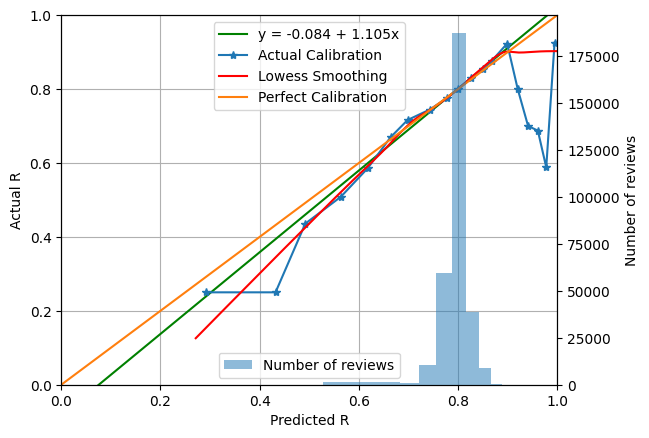

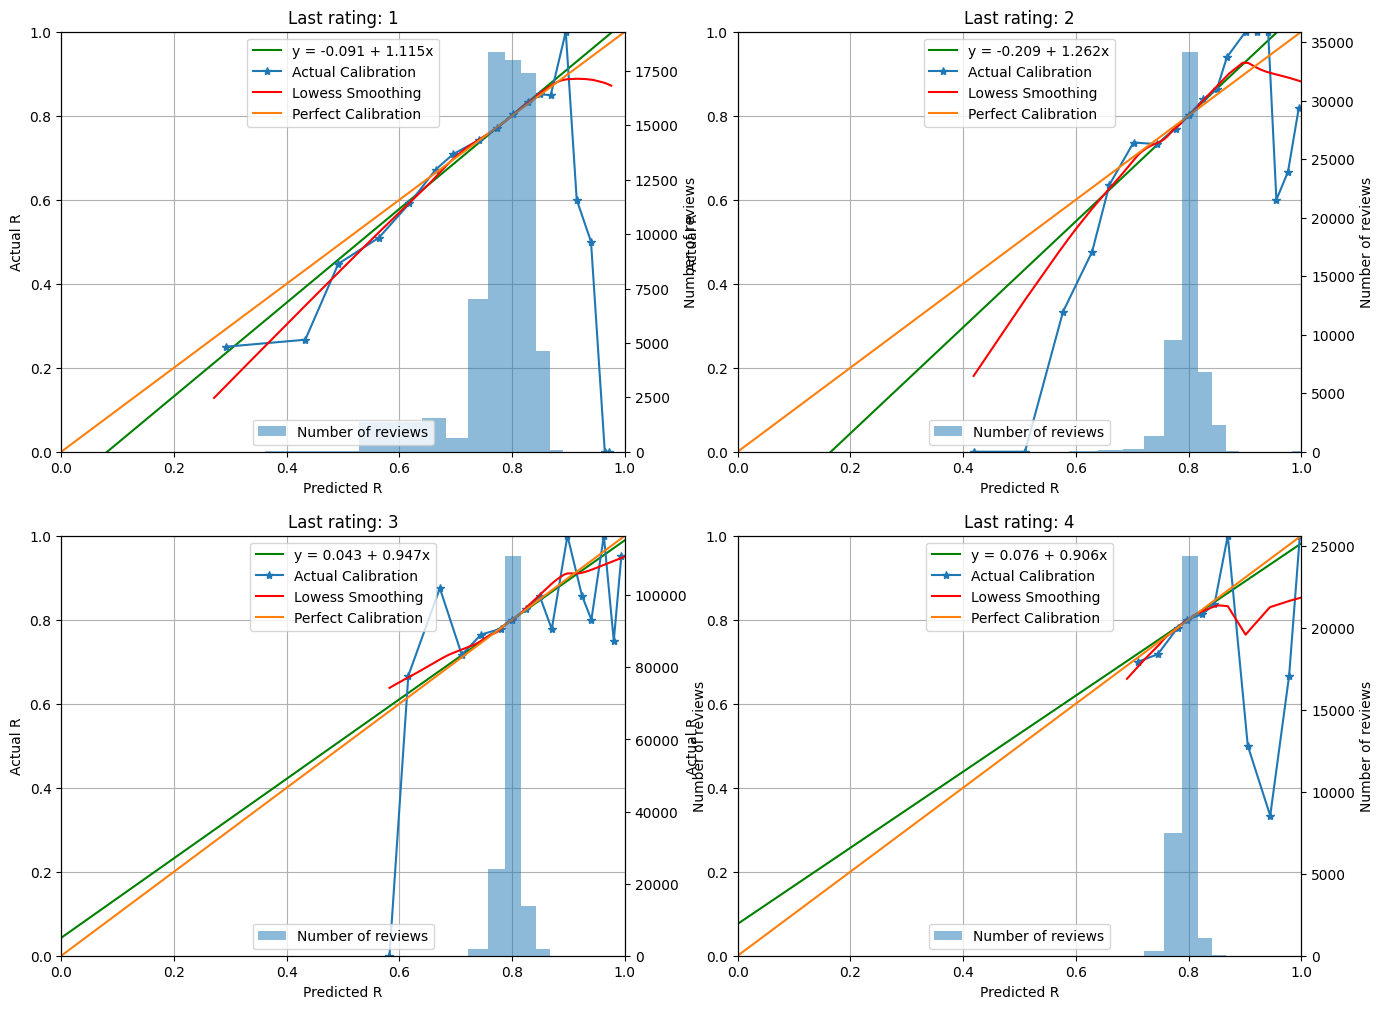

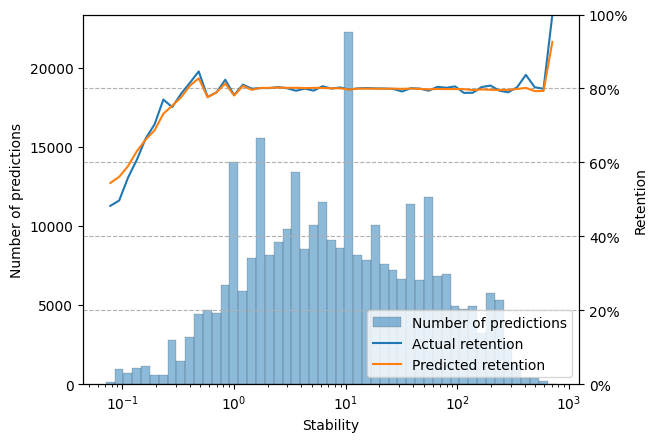

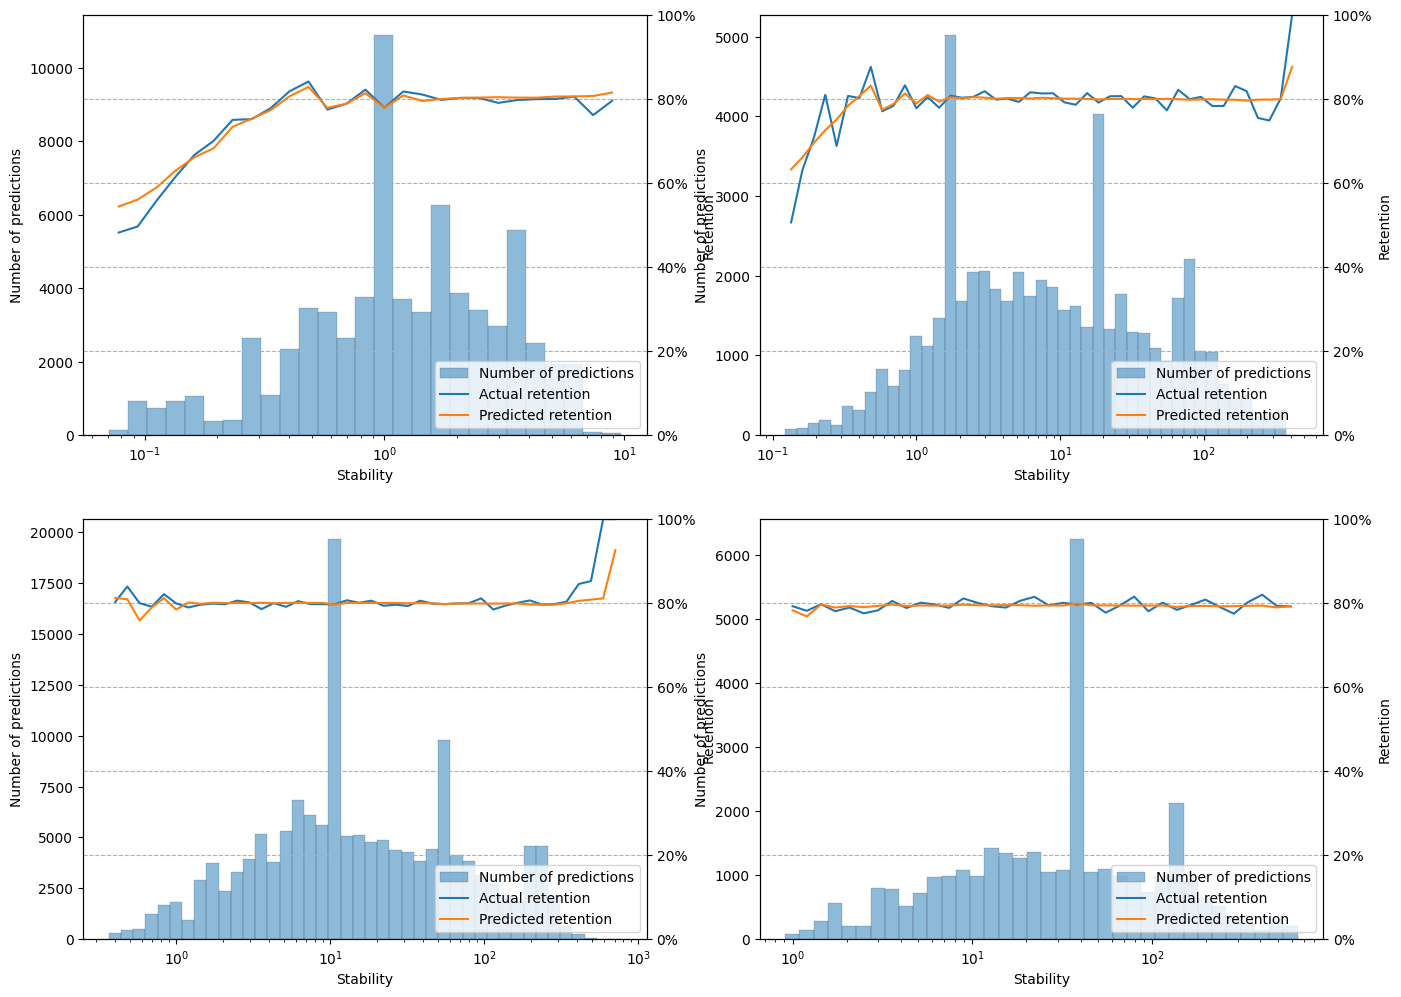

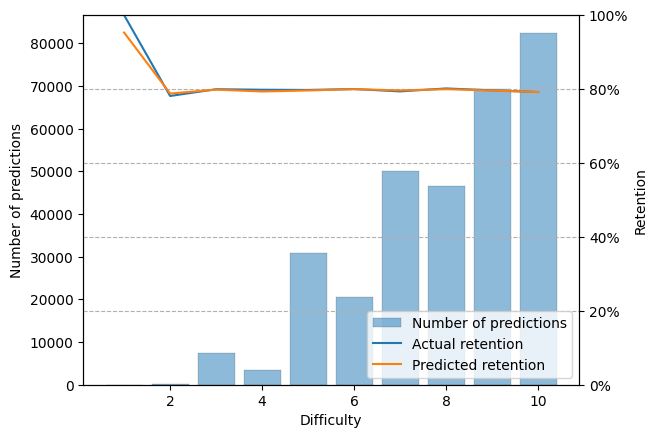

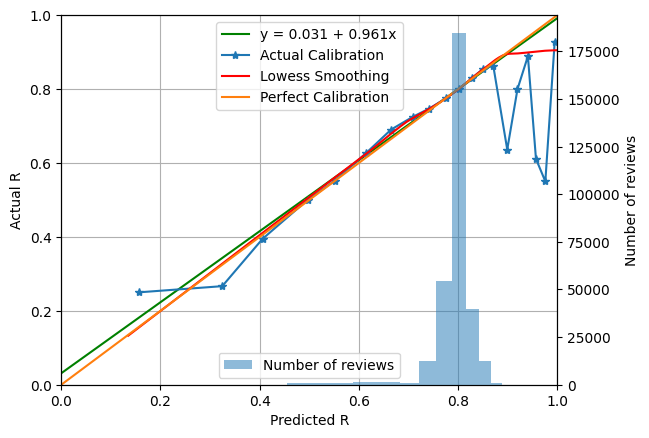

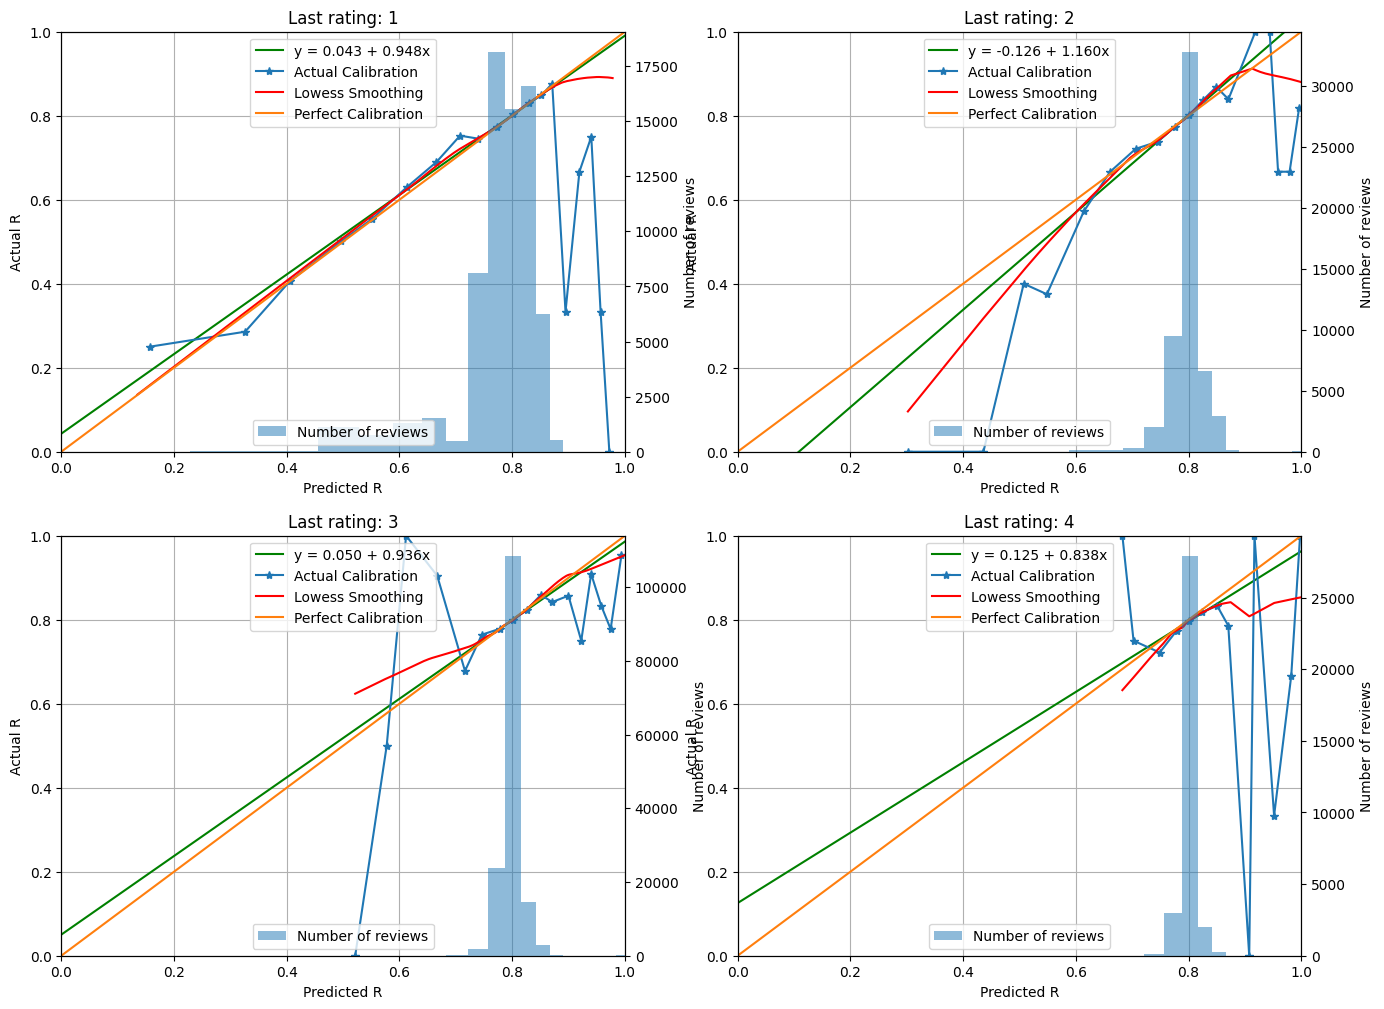

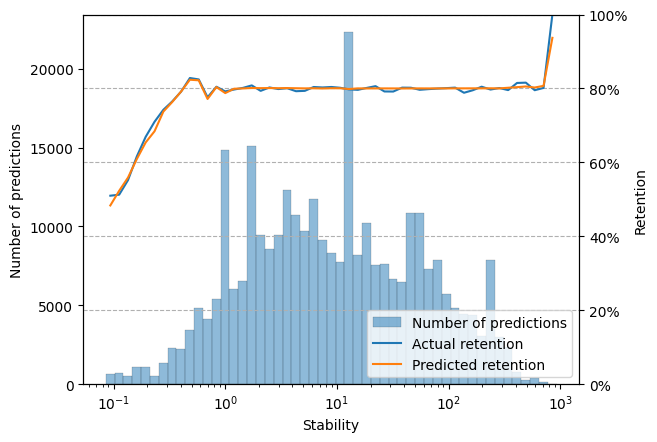

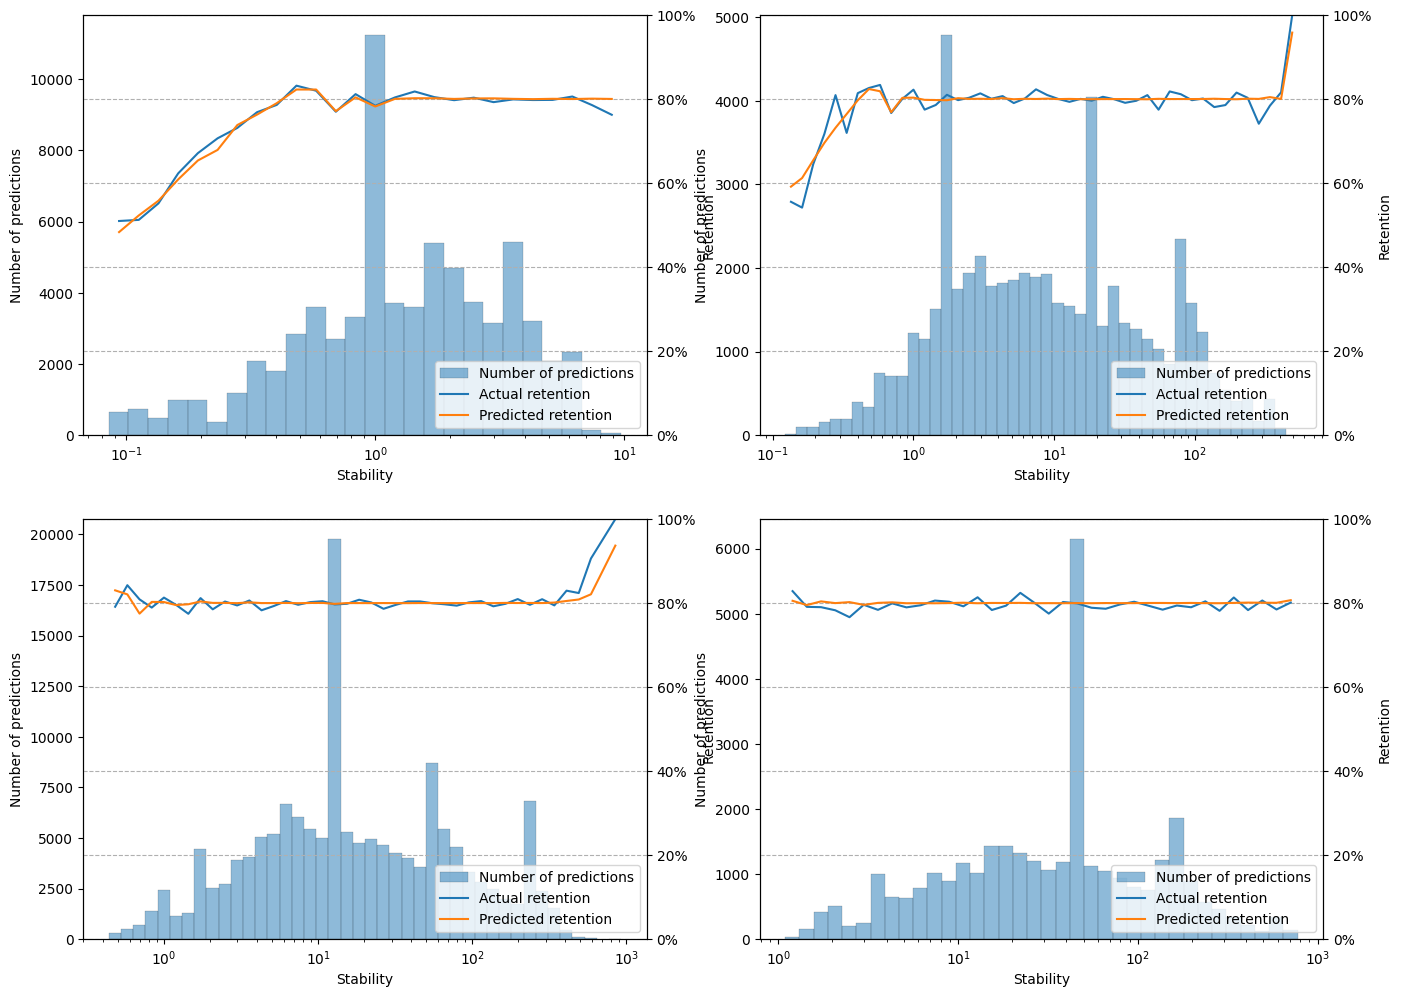

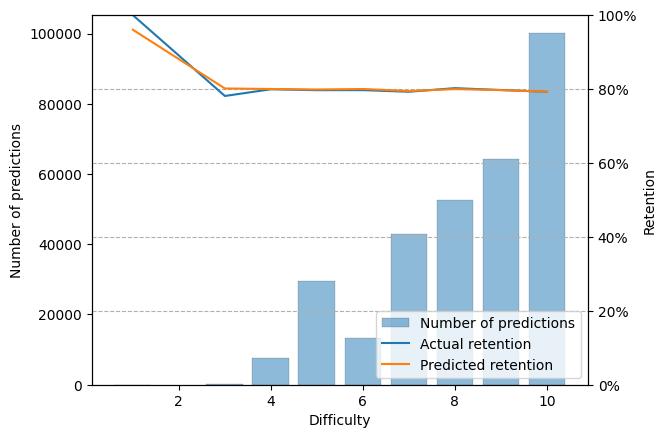

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

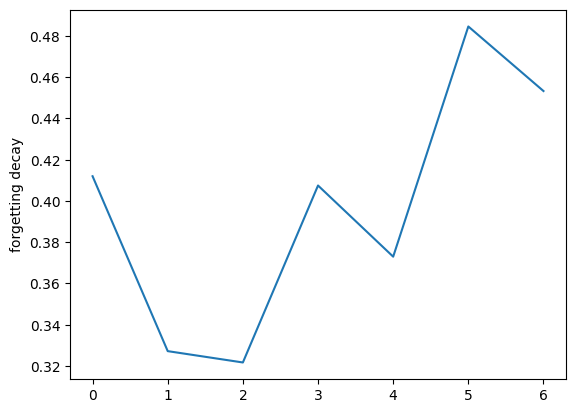

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.002803 -0.001036 -0.000431 -0.000075 -0.000014  0.000035  0.000089]
RMSE(bins) (trained - ideal): [-0.001267 -0.000434  0.000774 -0.000274  0.000508 -0.000027  0.000416]
AUC (trained - ideal): [ 0.001522 -0.002631 -0.001761 -0.000268  0.000203 -0.000182 -0.000804]


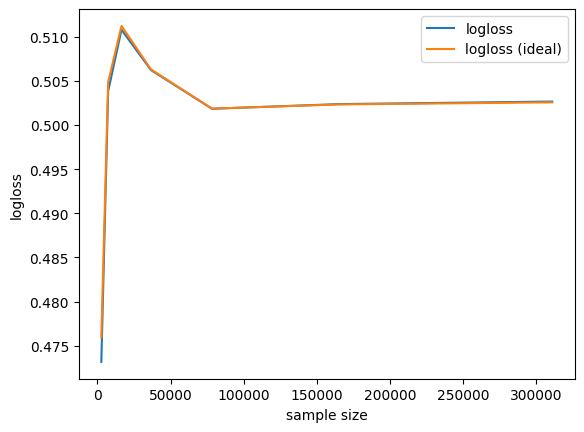

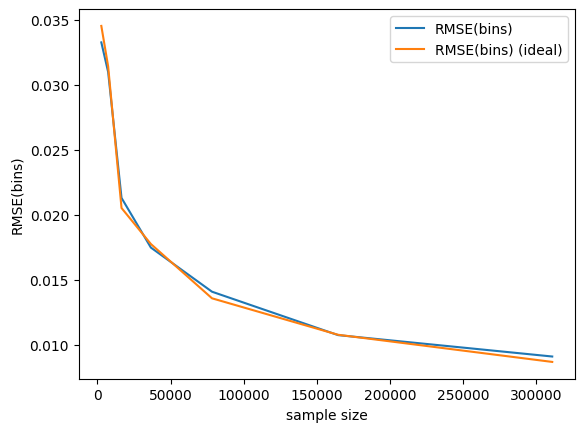

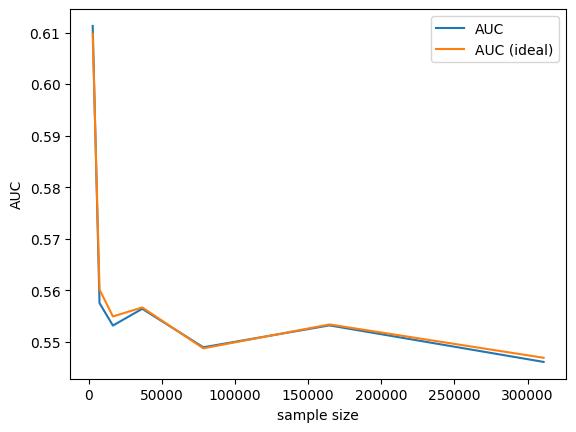

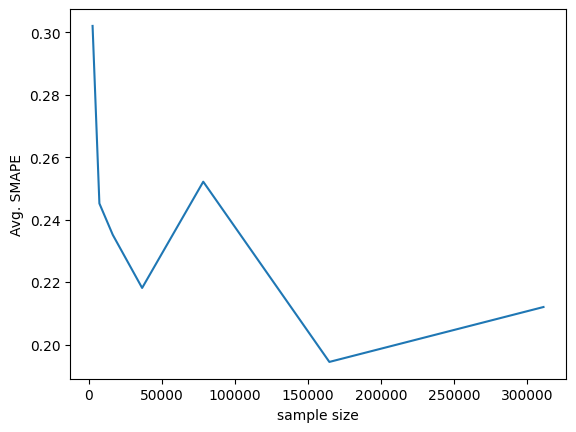

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

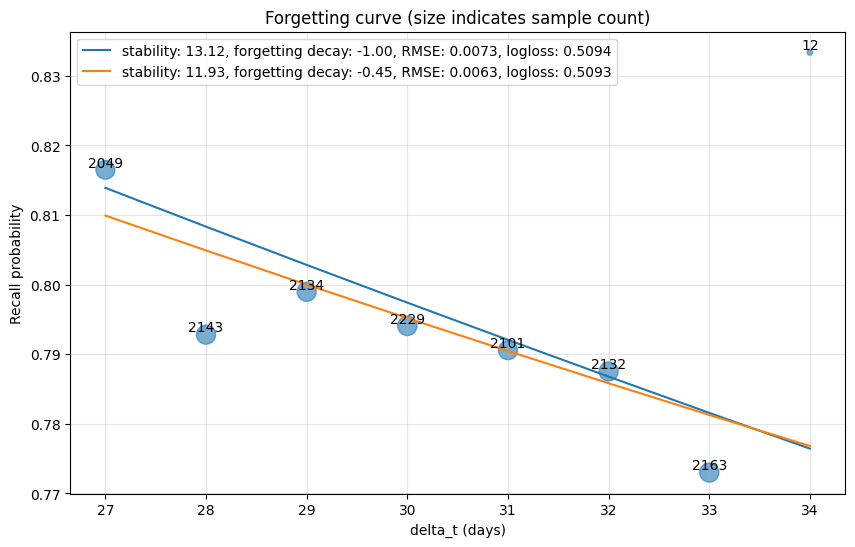

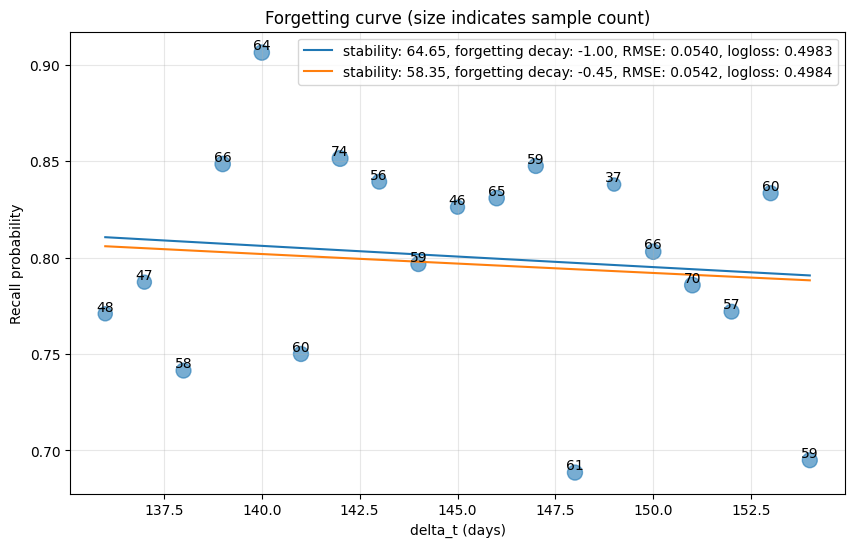

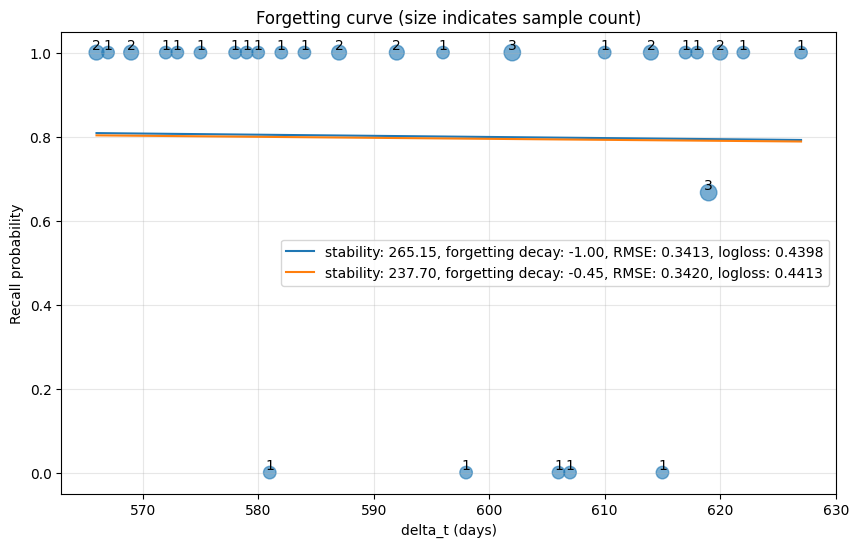

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [23]:
from fsrs_optimizer import FSRS
import torch

def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[19])
    print(next_interval, retention)

# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7974129587536983
145 0.8005118199232236
30 0.7951888794652493
145 0.7968663523884993
15 0.8872896513515888
40 0.9011828027678946
15 0.8790449709295418
40 0.8950348208833666
